In [52]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.model_selection import learning_curve, validation_curve

In [53]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# Get city dummy
city_dummy = pd.get_dummies(df['city'])
df = pd.concat([df,city_dummy],axis=1)

In [54]:
## Dataset split
# X and y
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # We have a relatively small dataset
seed = 17082023 

# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=test_size, random_state=seed)

<AxesSubplot: >

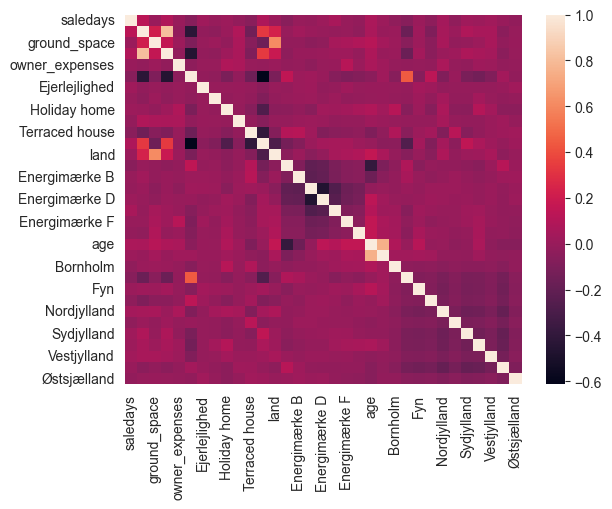

In [55]:
## Heat map
sns.heatmap(X.corr())


In [56]:
## Main model starts
# 3-degree Polynomial Regression
degree = 3
pipe_lr = make_pipeline(PolynomialFeatures(degree=degree), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [57]:
## Lasso
# PREPARATION
warnings.filterwarnings('ignore', category=ConvergenceWarning)

perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=degree), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=seed))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
# print('Optimal lambda:', optimal.index[0])
# print('Validation MSE: %.3f' % optimal.values[0])

In [ ]:
## Lasso 10-fold cross validation
warnings.filterwarnings('ignore', category=ConvergenceWarning)

kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:

    # Inner loop: folds
    mseCV_ = []
    for train_idx, val_idx in folds:

        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=degree, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=seed))            
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    

    # Store result    
    mseCV.append(mseCV_) 

# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)


In [ ]:
## Comparing Lasso CV, Lasso and Linear Reg
# Lasso CV
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=degree,include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=seed))
pipe_lassoCV.fit(X_dev,y_dev)

# Lasso
pipe_lasso = make_pipeline(PolynomialFeatures(degree=degree), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))
pipe_lasso.fit(X_dev, y_dev) 

# COMPARE MODEL PERFORMANCE ON TEST DATA
models = {'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    RMSE = mse(model.predict(X_test), y_test,squared=False)
    R2 = r2_score(model.predict(X_test), y_test)
    print(name, f'RMSE: {round(RMSE, 2)}', f'R2: {round(R2,2)}')

In [ ]:
## Drawing learning curve
# Learning curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)

# Plotting mean performance
f_learn, ax = plt.subplots(figsize=(7, 3))
ax.plot(train_sizes, np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label='Test',
        color='blue')  # negated, because we already use neg_MSE
ax.plot(train_sizes, np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train',
        color='orange')  # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Train size')
ax.legend();

In [ ]:
## Drawing validation curve
# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=10)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

# Plotting
np.sqrt(mse_score).plot(logx=True, figsize=(10,6));
plt.xlabel('lambda')
plt.ylabel('Mean squared error')
